In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import repeat
from extra_packages.OutputInterface import OutputInterface
import extra_packages.sperhical_expansion as se
import SFALinearPulse as SFA_Lin
from matplotlib.colors import LogNorm
from scipy.special import sph_harm
from scipy.optimize import curve_fit

In [2]:
import multiprocessing
#import ipyparallel as ipp
try:
    cpus = multiprocessing.cpu_count()
except NotImplementedError:
    cpus = 8   # arbitrary default
pool = multiprocessing.Pool(processes=cpus)

In [3]:
omega = 0.057     # Frequency of light
Up = 0.22         # Ponderomotive potential
CEP = np.pi/2     # This choice should make things symmetric

In [4]:
def plot_M_grid(M_grid, px_list, pz_list, log=False, log_scale = 1e-4):
    """
    Function to plot the calculated grids
    """
    plt.figure(facecolor='white', figsize=(12,6))

    M2_grid = np.abs(M_grid)**2
    MMax = np.max(M2_grid)

    if log:
        plt.imshow(np.flip(M2_grid,0), extent = (np.amin(pz_list), np.amax(pz_list), np.amin(px_list), np.amax(px_list)),
                   cmap='inferno', norm=LogNorm(vmin=MMax*log_scale, vmax=MMax),
                   interpolation = 'bicubic', aspect = 1.)
    else:
        plt.imshow(np.flip(M2_grid,0), extent = (np.amin(pz_list), np.amax(pz_list), np.amin(px_list), np.amax(px_list)),
                   cmap='inferno', interpolation = 'bicubic', aspect = 1.)

    plt.ylabel("$p_x$")
    plt.xlabel("$p_z$")
    plt.colorbar()
    plt.show()

In [5]:
file_name = 'output_files/CHBrClF.out'
output = OutputInterface(file_name)
orbital_nr = None

if orbital_nr == None:
    orbital_nr = output.HOMO
else:
    output.load_orbital(orbital_nr)

Ip = -output.saved_orbitals[orbital_nr][0]
kappa = np.sqrt(2*Ip)
GTO_coeffs = np.array(output.output_GTOs(orbital_nr))

In [13]:
r_list = np.linspace(10, 14, 50)
clm_array = se.get_asymp_fit(output.eval_orbital_spherical, r_list, 50, Ip, orbital_nr=orbital_nr, threshold=1e-4)

Evaluating at r=14.0000 	 Nr. 50/50
Now fitting!
Done!


In [33]:
clm_array[0, 20, 1]

0j

In [21]:
plot_list = np.linspace(1, 16, 75)
f_lms = se.laplace_several_r(output.eval_orbital_spherical, plot_list, 50, orbital_nr=orbital_nr)

Evaluating at r=16.0000 	 Nr. 75/75

In [7]:
def asymp(r, clm):
    return clm * r**(1/kappa - 1) * np.exp(-kappa*r)

sign, l, m = 1, 3, 2

plt.figure(facecolor='white')
plt.plot(plot_list, np.abs(f_lms[:, sign, l, m]), label='Laplace')
plt.plot(plot_list, np.abs(asymp(plot_list, clm_array[sign, l, m])), label='Asymp.')
plt.xlabel('$r$ (a.u.)')
plt.ylabel('Absolute amplitude')
plt.legend(frameon=False)
#plt.yscale('log')
plt.show()

NameError: name 'plot_list' is not defined

<Figure size 432x288 with 0 Axes>

### Let's look at SFA results with this...

In [10]:
N = 50
pz_list = np.linspace(-1.5, 1.5, N)
px_list = np.linspace(-1, 1., N)
pzGrid, pxGrid = np.meshgrid(pz_list, px_list)
py = 0.

In [11]:
SP_asymp_martiny = SFA_Lin.SFALinearPulse(Ip, Up, omega, 2, CEP, target_="asymp_martiny")

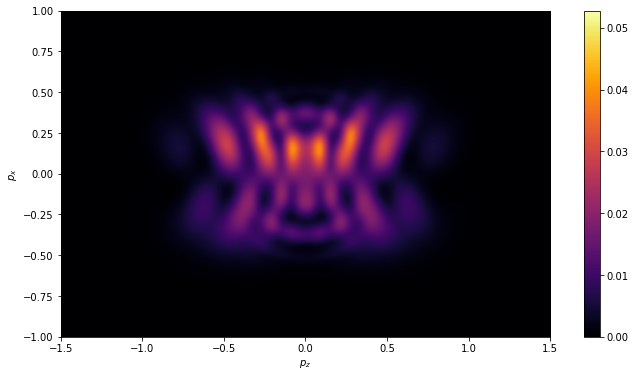

In [16]:
M_grid = np.array(pool.starmap(SP_asymp_martiny.Mxz_List, zip(pxGrid, repeat(py), pzGrid, repeat(clm_array))))
plot_M_grid(M_grid, px_list, pz_list, log=False)

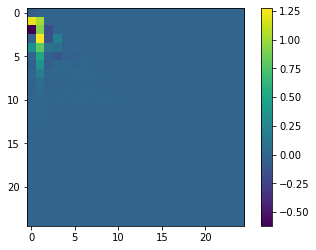

In [14]:
plt.imshow(np.real(clm_array[0]), interpolation='None')
plt.colorbar()